### Chapter 6 Problem 5 (Gelman & Hill)

*Tobit model for mixed discrete/continuous data: experimental data from the National Supported Work example are available in the folder `lalonde`. Use the treatment indicator and pre-treatment variables to predict post-treatment (1978) earnings using a tobit model. Interpret the model coefficients.*

In [87]:
options(warn=-1)

require("arm")
require("foreign")
require("ggplot2")
require("VGAM")
require("gridExtra")

Loading required package: VGAM
Loading required package: stats4
Loading required package: splines

Attaching package: ‘VGAM’

The following object is masked from ‘package:arm’:

    logit



In [2]:
nsw <- read.dta("http://www.stat.columbia.edu/~gelman/arm/examples/lalonde/NSW.dw.obs.dta")

# normalise and standardise
nsw$c.age <- (nsw$age - mean(nsw$age)) / (2 * sd(nsw$age))
nsw$c.educ <- (nsw$educ - mean(nsw$educ)) / (2 * sd(nsw$educ))
nsw$c.re74 <- (nsw$re74 - mean(nsw$re74)) / (2 * sd(nsw$re74))
nsw$c.re75 <- (nsw$re75 - mean(nsw$re75)) / (2 * sd(nsw$re75))
nsw$c.re78 <- (nsw$re78 - mean(nsw$re78)) / (2 * sd(nsw$re78))
nsw$c.re75 <- (nsw$re75 - mean(nsw$re75)) / (2 * sd(nsw$re75))
nsw$sample <- factor(nsw$sample, labels=c("NSW", "CPS", "PSID"))
nsw$black <- factor(nsw$black)
nsw$hisp <- factor(nsw$hisp)
nsw$nodegree <- factor(nsw$nodegree)
nsw$married <- factor(nsw$married)
nsw$treat <- factor(nsw$treat)
nsw$educ_cat4 <- factor(nsw$educ_cat4, labels=c("less than high school", "high school", "sm college", "college"))

summary(nsw)

      age             educ       black     married   nodegree       re74       
 Min.   :16.00   Min.   : 0.00   0:16711   0: 5093   0:13045   Min.   :     0  
 1st Qu.:24.00   1st Qu.:11.00   1: 1956   1:13574   1: 5622   1st Qu.:  4898  
 Median :31.00   Median :12.00                                 Median : 15525  
 Mean   :33.37   Mean   :12.02                                 Mean   : 14621  
 3rd Qu.:42.00   3rd Qu.:14.00                                 3rd Qu.: 23882  
 Max.   :55.00   Max.   :18.00                                 Max.   :137149  
      re75             re78        hisp       sample      treat    
 Min.   :     0   Min.   :     0   0:17423   NSW :  185   0:18482  
 1st Qu.:  4726   1st Qu.:  6158   1: 1244   CPS :15992   1:  185  
 Median : 14899   Median : 16957             PSID: 2490            
 Mean   : 14253   Mean   : 15657                                   
 3rd Qu.: 23274   3rd Qu.: 25565                                   
 Max.   :156653   Max.   :121174

The following variables are included in the NSW data set from the Dehejia/Wahba paper.
The dataset you are given only includes

1.	sample: 1 = NSW; 2 = CPS; 3 = PSID.
2.	treat: 1 = experimental treatment group (NSW); 0 = comparison group (either from CPS or PSID)   Treatment took place in 1976/1977.
3.	age  = age in years
4.	educ = years of schooling
5.	black: 1 if black; 0 otherwise.
6.	hisp: 1 if Hispanic; 0 otherwise.
7.	married: 1 if married; 0 otherwise.
8.	nodegree: 1 if no high school diploma; 0 otherwise.
9.	re74, re75, re78: real earnings in 1974, 1975 and 1978
10.	educ_cat = 4 category education variable (1=<hs, 2=hs, 3=sm college, 4=college)



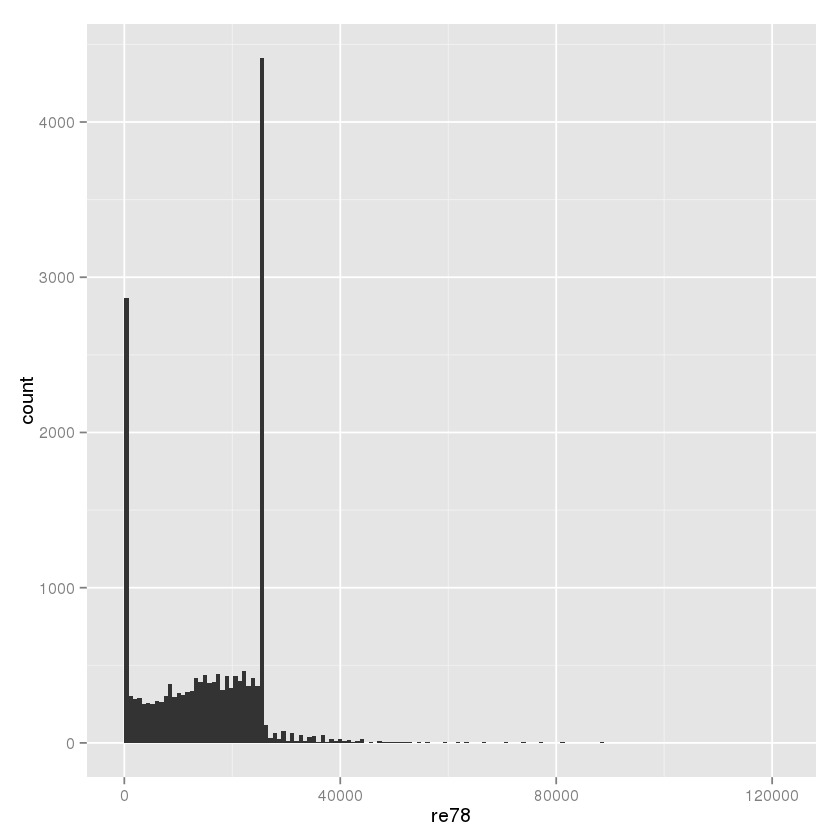

In [161]:
ggplot(data=nsw, aes(x=re78)) + geom_histogram(binwidth=(range(nsw$re78)[2] - range(nsw$re78)[1])/150)

[1] "The mode is: 25564.669921875"


stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


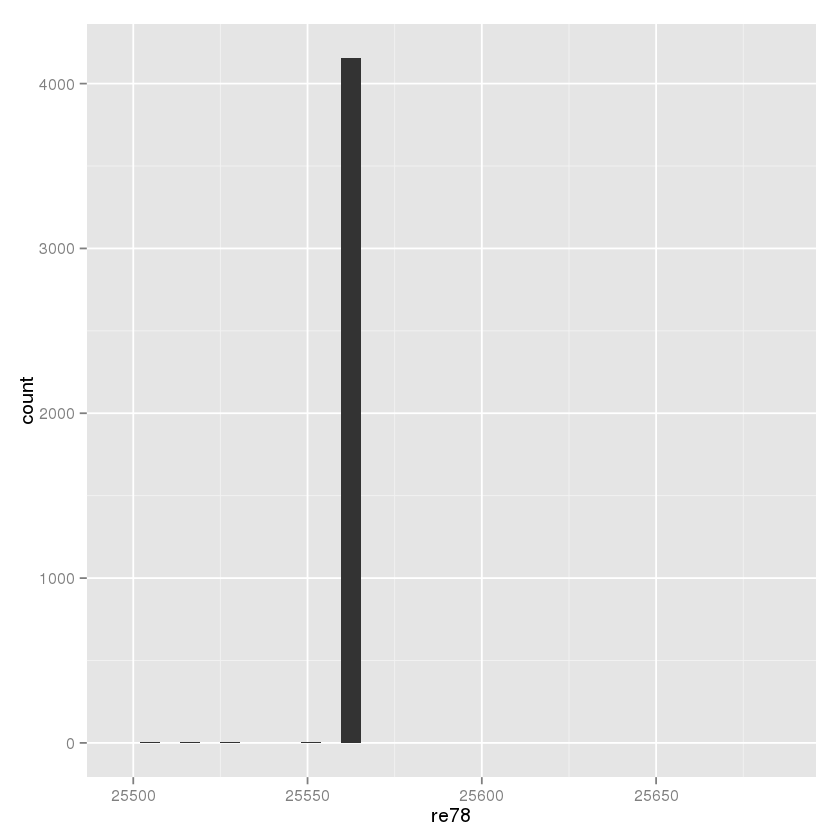

In [155]:
modex <- function(x) {  # call it modex not to override the standard mode command
    ux <- unique(x)
    ux[which.max(tabulate(match(x, ux)))]
}

print(paste0("The mode is: ", modex(nsw$re78)))
ggplot(nsw[nsw$re78>=25500 & nsw$re78<25700,], aes(x=re78)) + geom_histogram()

`re78` has a very clear bi-modal distribution, concentrated on the values 0 and 25,564.67. The rest on the density is mainly distributed between these two values, with rare observations over 25,564.67. From the previous series of commands we notice the distribution around the value 25,564.67 is not random. The value for some reason appears very often. This looks like a case of censored data. In particular, it seems that there are two underlying distributions: 1) values from 0 to 25,563 and 2) from 25,564.67 to approximately 100,000.

To model such distribution, we will start fitting a logistic regression to classify observations as to belog to a value lower than or greater than 25,564.67. Then we will split the dataset into two smaller sets, based on the predictions of the logistic model. As a final stage, we will fit two Tobit regressions, to predict the `re78` variables from zero to 25,563 and from 25,564 to Inf.

We will proceed creating a binary variable that takes value `gte` when earnings in 1978 are greater or equal than $25,564.67, or `lt` when lower than that threshold. We will use this variable as the outcome variable of the logistic regression model.

In [63]:
nsw$outcome <- rep(NA, nrow(nsw))
nsw$outcome <- ifelse(nsw$re78>=25564.669921875, 1, 0)
nsw$outcome <- factor(nsw$outcome, labels=c("lt", "gte"))

We will plot a few variables against the new created `outcome` variable to have a better understanding of which variables we should include in our logistic regression model. 

     
          0     1
  lt  11947  1666
  gte  4764   290

     
          0     1
  lt  12594  1019
  gte  4829   225

     
         0    1    2    3    4    5    6    7    8    9   10   11   12   13
  lt    37   12   40   78  107  125  239  293  837  811 1116 1073 5165  867
  gte    2    2    6   11   13   17   39   45  182  142  203  192 1979  353
     
        14   15   16   17   18
  lt   882  383  932  281  335
  gte  465  155  719  263  266

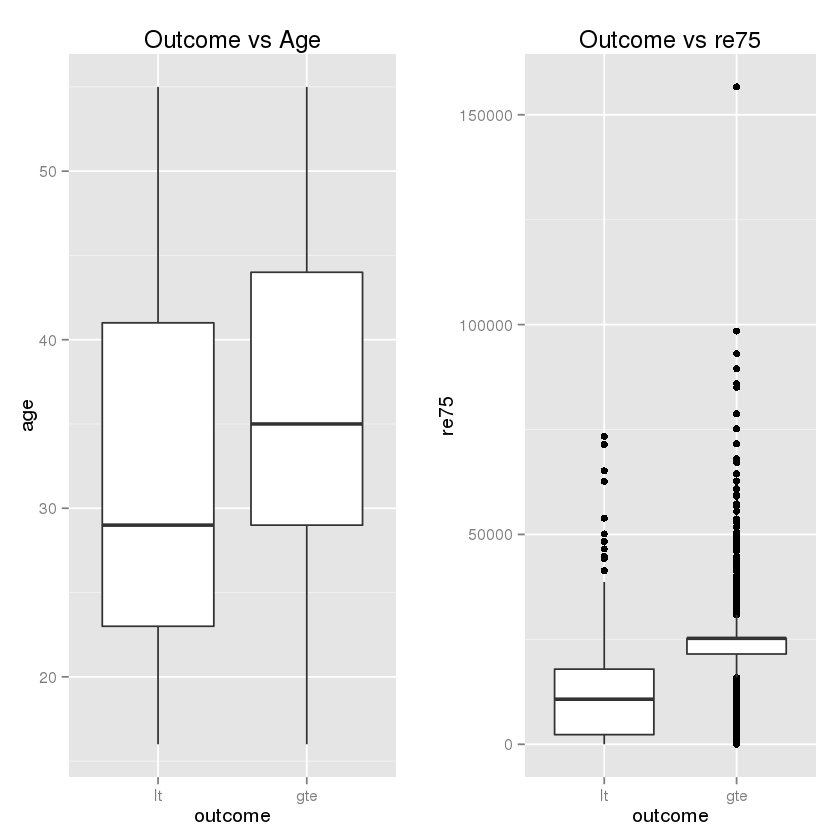

In [64]:
p1 <- ggplot(data=nsw, aes(x=outcome, y=age)) + geom_boxplot() + labs(title="Outcome vs Age")
p2 <- ggplot(data=nsw, aes(x=outcome, y=re75)) + geom_boxplot() + labs(title="Outcome vs re75")
grid.arrange(p1, p2, nrow=1)

table(nsw$outcome, nsw$black)
table(nsw$outcome, nsw$hisp)
table(nsw$outcome, nsw$educ)

In [75]:
m1 <- glm(outcome ~ c.age + c.educ + c.re75 + black + married, family=binomial(link="logit"), data=nsw)
display(m1)

glm(formula = outcome ~ c.age + c.educ + c.re75 + black + married, 
    family = binomial(link = "logit"), data = nsw)
            coef.est coef.se
(Intercept) -1.93     0.06  
c.age       -0.05     0.05  
c.educ       0.66     0.05  
c.re75       3.89     0.07  
black1      -0.30     0.08  
married1     0.33     0.06  
---
  n = 18667, k = 6
  residual deviance = 14505.0, null deviance = 21803.0 (difference = 7298.1)


In [76]:
predicted <- predict(m1, nsw, type="response")
y <- ifelse(nsw$re78>=25564.669921875, 1, 0)
error.rate <- mean((predicted>0.5 & y==0) | (predicted<.5 & y==1))
error.rate

[1] 0.1587829

The logistic regression achieves an error rate (on the training set) of just 16%. This is quite a decent starting point. We will now use the predictions from this first model to divide the dataset into two smaller sets. The first one will be used to fit a Tobit regression with the aim of predicting `re78` values from 0 to $25,563, and a second set to predict values above such threshold.

In [77]:
nsw$predicted.outcome <- predict(m1, nsw, type="response")
set1 <- nsw[nsw$predicted.outcome<0.5,]
set2 <- nsw[nsw$predicted.outcome>=0.5,]

In [89]:
m2 <-vglm(re78 ~ c.age + c.educ + c.re75, tobit(Lower=0, Upper=25563), data=set1)
summary(m2)


Call:
vglm(formula = re78 ~ c.age + c.educ + c.re75, family = tobit(Lower = 0, 
    Upper = 25563), data = set1)

Pearson residuals:
            Min      1Q  Median     3Q   Max
mu       -1.564 -0.7986 -0.1424 0.6019 2.291
loge(sd) -1.007 -0.8087 -0.5449 0.3305 9.502

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept):1  1.598e+04  9.755e+01  163.803  < 2e-16 ***
(Intercept):2  9.131e+00  7.771e-03 1175.063  < 2e-16 ***
c.age         -3.198e+03  1.714e+02  -18.664  < 2e-16 ***
c.educ         6.515e+02  1.692e+02    3.851 0.000118 ***
c.re75         1.964e+04  2.372e+02   82.801  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Number of linear predictors:  2 

Names of linear predictors: mu, loge(sd)

Dispersion Parameter for tobit family:   1

Log-likelihood: -108604.8 on 27525 degrees of freedom

Number of iterations: 7 

In [115]:
m3 <- vglm(re78 ~ c.age + c.educ + c.re75, tobit(Lower=25564), data=set2)
summary(m3)


Call:
vglm(formula = re78 ~ c.age + c.educ + c.re75, family = tobit(Lower = 25564), 
    data = set2)

Pearson residuals:
             Min      1Q   Median      3Q   Max
mu       -11.658 -0.6328  0.07031  0.2456  14.2
loge(sd)  -1.009 -0.9991 -0.93598 -0.1886 163.2

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept):1  1.476e+04  1.783e+02  82.808  < 2e-16 ***
(Intercept):2  8.513e+00  1.402e-02 607.205  < 2e-16 ***
c.age         -6.630e+02  2.010e+02  -3.298 0.000975 ***
c.educ         1.264e+03  1.927e+02   6.563 5.28e-11 ***
c.re75         1.890e+04  2.526e+02  74.816  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Number of linear predictors:  2 

Names of linear predictors: mu, loge(sd)

Dispersion Parameter for tobit family:   1

Log-likelihood: -35604.43 on 9799 degrees of freedom

Number of iterations: 13 

Treatment is not statistically significant neither in `m2` or `m3` models. Therefore we proceeded removing it from the model specifications. In addition to that, in the second Tobit model (`m3`) including `treat` as a predictor leads to a *nonidentifiability* issue.

To benchmark out models, we will compute the root-mean-square error (RMSE) on the training data. This is an overly optimistic statistic but, in absence of unseen data, is a decent starting point for evaluating out models. On a real world application we would do cross-validation to avoid overfitting the data. However, for the purposes of this exercise we will not apply such technique.

[1] 7690.451

[1] 0

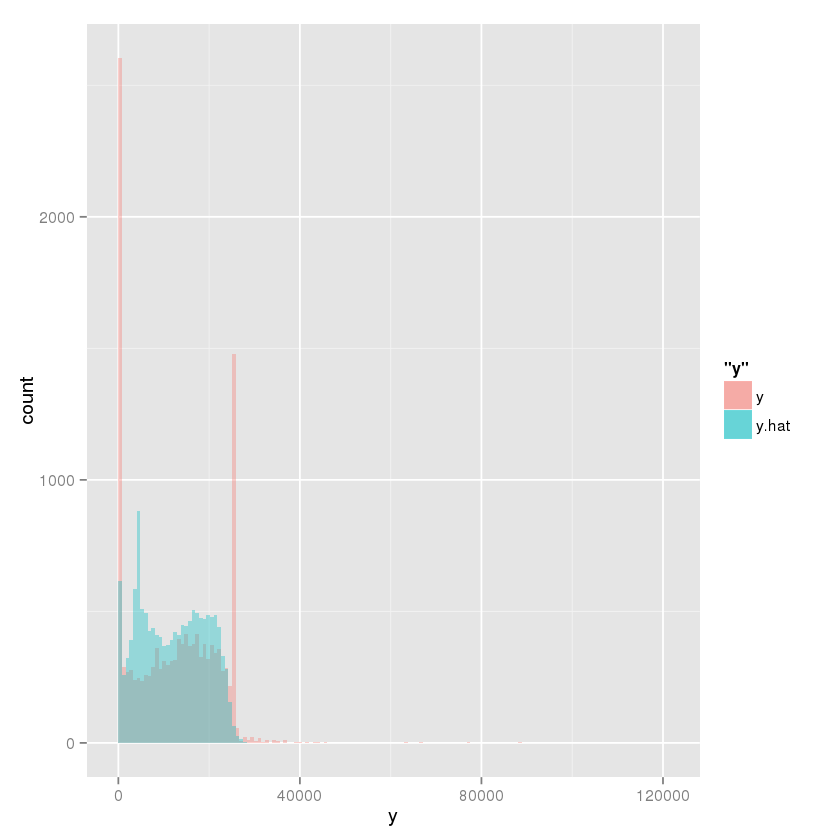

In [164]:
y.hat <- ifelse(predict(m2, set1)[,1]<0, 0, predict(m2, set1)[,1]) # predicted values can't go below 0
y <- set1$re78
sqrt(mean((y-y.hat)**2))
first <- data.frame(cbind(y, y.hat))
min(y.hat)
ggplot(data=first) + geom_histogram(aes(x=y, fill="y"), alpha=.35, binwidth=(range(first$y)[2] - range(first$y)[1])/150) + geom_histogram(aes(x=y.hat, fill="y.hat"), alpha=.35, binwidth=(range(first$y)[2] - range(first$y)[1])/150)

[1] 8412.494

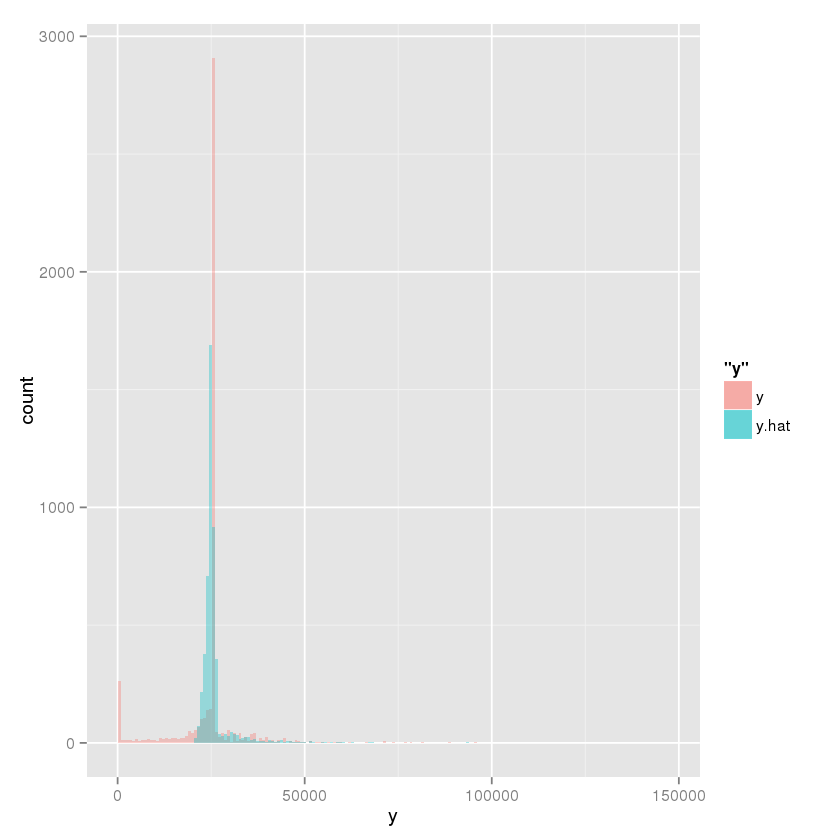

In [165]:
y.hat <- predict(m3, set2)[,1] # in this case we actually know values can go below 25,564 so we won't manually censor them
y <- set2$re78
sqrt(mean((y-y.hat)**2))
second <- data.frame(cbind(y, y.hat))
ggplot(data=second) + geom_histogram(aes(x=y, fill="y"), alpha=.35, binwidth=(range(second$y)[2] - range(second$y)[1])/150) + geom_histogram(aes(x=y.hat, fill="y.hat"), alpha=.35, binwidth=(range(second$y)[2] - range(second$y)[1])/150)

In [146]:
mean(second$y.hat<25564 & set2$re78<25564.67)

[1] 0.6970624

In model `m3`, almost 70% of the predicted value below the 25,564 threshold are actually associated with an observed outcome below such value. This means our level 1 model (Tobit model) correctly predict those values that the logit model mistakenly predicted to be above the threshold.